In [ ]:
# With ten qubits it's possible to produce a skewed distribution with 5 shots.

In [113]:
num_qubits = 5

In [114]:
import networkx as nx
from networkx.generators import erdos_renyi_graph
g = erdos_renyi_graph(num_qubits, .7)

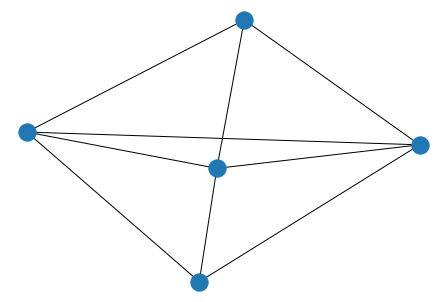

In [115]:
from networkx.drawing import draw
draw(g)

In [116]:
from classical_optimization.qaoa_circuits import maxcut_qaoa_circuit, estimate_cost
from qiskit import Aer, execute
import numpy as np
# We're going to look at the concentration of the wavefunction when given (brute force located) optimal parameters

discretization = 10
max_gamma = 2*np.pi
max_beta = np.pi
num_shots = 10000
weights = {}
for edge in g.edges:
    weights[edge] = np.random.rand()
def produce_gammas_betas(discretization, max_gamma, max_beta):
    return np.linspace(0, max_gamma, discretization), np.linspace(0, max_beta, discretization)
gammas, betas = produce_gammas_betas(discretization, max_gamma, max_beta)

simulator = Aer.get_backend('qasm_simulator')
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=num_qubits, cols=1, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()    
landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

In [117]:
len(g.edges)

9

In [118]:
gamma_index, beta_index = np.where(landscape==np.max(landscape))
num_samples = 1000
num_shots = 5
experiments = [maxcut_qaoa_circuit(gammas=[gammas[gamma_index]], betas=[betas[beta_index]], p=1, rows=num_qubits, cols=1, weights=weights) for _ in range(num_samples)]
job = execute(experiments, backend=simulator, shots=num_shots) 
all_counts = job.result().get_counts()

In [119]:
costs = []
for count in all_counts:
    costs.append(estimate_cost(count, weights))

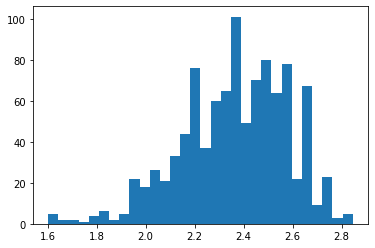

1.0

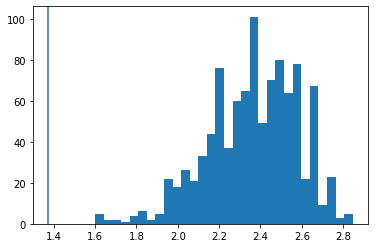

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline

def integrate_to(bins, counts, threshold_value):
    total = sum(bins)
    running_total = 0
    for i, bin_ in enumerate(bins):
        if bin_ < threshold_value:
            running_total += counts[i]
        else:
            break
    return 1 - running_total/sum(counts)
counts, bins, _ = plt.hist(costs, bins=30)
plt.axvline(np.max(landscape) - 1)

integrate_to(bins, counts, np.max(landscape) - 1)

1.0

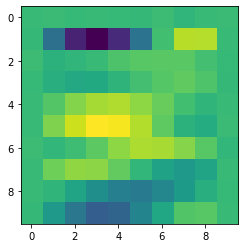

In [144]:
plt.imshow(landscape)

In [145]:
np.max(landscape)

2.3746550356952283